In [2]:
# Install required libraries
!pip install torch deap opencv-python tqdm scikit-learn matplotlib --quiet
!pip install deap

# Imports
import os
import cv2
import numpy as np
from tqdm import tqdm
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import zipfile
import tarfile
import time
import pickle
import concurrent.futures

# Set seed for reproducibility
np.random.seed(42)

In [3]:
# Clean any previous data
!rm -rf 101_ObjectCategories
!rm -f caltech-101.zip

# Download Caltech-101 dataset
!wget -q -O caltech-101.zip https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip

# Extract zip
with zipfile.ZipFile('caltech-101.zip', 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not file.startswith('__MACOSX/'):
            try:
                zip_ref.extract(file, path='.')
            except:
                pass

# Extract .tar.gz inside
with tarfile.open('caltech-101/101_ObjectCategories.tar.gz', 'r:gz') as tar_ref:
    tar_ref.extractall(path='.')


In [4]:
# Function to load a single image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return cv2.resize(img, (140, 140))
    return None

# Function to load class images
def load_class_images(class_name, max_images=60, include_negatives=True):
    base_path = "101_ObjectCategories"
    pos_images, neg_images = [], []

    pos_folder = next((f for f in os.listdir(base_path) if f.lower() == class_name.lower()), None)
    if pos_folder:
        pos_path = os.path.join(base_path, pos_folder)
        image_paths = [os.path.join(pos_path, img_file)
                       for img_file in os.listdir(pos_path)[:max_images]
                       if img_file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Parallel image loading
        with concurrent.futures.ThreadPoolExecutor() as executor:
            pos_images = [img for img in executor.map(load_image, image_paths) if img is not None]

    if include_negatives:
        neg_folder = "BACKGROUND_Google"
        neg_path = os.path.join(base_path, neg_folder)
        if os.path.exists(neg_path):
            neg_samples = min(3 * len(pos_images), 3 * max_images)
            neg_image_paths = [os.path.join(neg_path, img_file)
                               for img_file in os.listdir(neg_path)[:neg_samples]
                               if img_file.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Load negative images in parallel
            with concurrent.futures.ThreadPoolExecutor() as executor:
                neg_images = [img for img in executor.map(load_image, neg_image_paths) if img is not None]

    min_samples = min(len(pos_images), len(neg_images))
    if min_samples == 0:
        print(f"Warning: No samples for {class_name}")
        return None, None

    images = pos_images[:min_samples] + neg_images[:min_samples]
    labels = [1] * min_samples + [0] * min_samples
    return images, labels

# Load only Face and Motorbike
face_images, face_labels = load_class_images("faces_easy")
motorbike_images, motorbike_labels = load_class_images("Motorbikes")

# Filter only valid loaded classes
classes = {
    k: v for k, v in {
        'Face': (face_images, face_labels),
        'Motorbike': (motorbike_images, motorbike_labels)
    }.items() if v[0] is not None
}


In [7]:
# ----------------------------
# Gabor filter generation
# ----------------------------
def generate_gabor_filters(ksize=7):
    filters = []
    for theta in range(4):  # 4 orientations
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.pi / np.array([4, 2]):
                kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
                filters.append(kern)
    return filters

# ----------------------------
# Apply Gabor filters to grayscale image
# ----------------------------
def apply_gabor_filters(img, filters):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    responses = [cv2.filter2D(gray, cv2.CV_32F, f) for f in filters]
    return responses

# ----------------------------
# S1 Layer (simple cells)
# ----------------------------
def compute_S1(img, gabor_filters):
    return apply_gabor_filters(img, gabor_filters)

# ----------------------------
# Max pooling for C1 Layer
# ----------------------------
def max_pooling(img, pool_size):
    h, w = img.shape
    pooled = np.zeros((h // pool_size, w // pool_size), dtype=np.float32)
    for i in range(0, h - pool_size + 1, pool_size):
        for j in range(0, w - pool_size + 1, pool_size):
            pooled[i // pool_size, j // pool_size] = np.max(img[i:i + pool_size, j:j + pool_size])
    return pooled

def compute_C1(s1_maps, pool_size=10):
    return [max_pooling(fmap, pool_size) for fmap in s1_maps]

# ----------------------------
# Better random patch extraction
# ----------------------------
def extract_random_patches(c1_maps_list, num_patches=100, patch_size=(4, 4)):
    patches = []
    attempts = 0
    max_attempts = num_patches * 20

    while len(patches) < num_patches and attempts < max_attempts:
        c1_maps = c1_maps_list[np.random.randint(len(c1_maps_list))]
        fmap = c1_maps[np.random.randint(len(c1_maps))]
        h, w = fmap.shape

        if h < patch_size[0] or w < patch_size[1]:
            attempts += 1
            continue

        y = np.random.randint(0, h - patch_size[0] + 1)
        x = np.random.randint(0, w - patch_size[1] + 1)
        patch = fmap[y:y + patch_size[0], x:x + patch_size[1]].flatten()
        patches.append(patch)
        attempts += 1

    print(f"Sampled {len(patches)} patches.")
    return patches

# ----------------------------
# C2 Layer: Compute features from C1 maps
# ----------------------------
def compute_C2(c1_maps_list, patches, patch_size=(4, 4)):
    c2_features = []
    for c1_maps in c1_maps_list:
        fmap_features = []
        for patch in patches:
            min_dist = float('inf')
            for fmap in c1_maps:
                h, w = fmap.shape
                for i in range(0, h - patch_size[0] + 1, max(1, patch_size[0] // 2)):
                    for j in range(0, w - patch_size[1] + 1, max(1, patch_size[1] // 2)):
                        region = fmap[i:i + patch_size[0], j:j + patch_size[1]].flatten()
                        if region.shape != patch.shape:
                            continue
                        dist = np.linalg.norm(region - patch)
                        if dist < min_dist:
                            min_dist = dist
            fmap_features.append(min_dist)
        c2_features.append(fmap_features)
    return np.array(c2_features)

# ----------------------------
# Full evaluation pipeline
# ----------------------------
def evaluate_class(images, labels, model_name, patch_counts, patch_size=(4, 4)):
    gabor_filters = generate_gabor_filters()
    results = []

    for num_patches in patch_counts:
        print(f"\n[{model_name}] Num patches: {num_patches}")

        # Step 1: S1 and C1
        s1_list = [compute_S1(img, gabor_filters) for img in tqdm(images)]
        c1_list = [compute_C1(s1) for s1 in s1_list]

        # Step 2: Extract patches
        patches = extract_random_patches(c1_list, num_patches, patch_size=patch_size)

        if len(patches) == 0:
            print(f"[{model_name}] WARNING: No patches extracted.")
            results.append(0.0)
            continue

        # Step 3: C2 feature computation
        features = compute_C2(c1_list, patches, patch_size=patch_size)

        if features.shape[1] == 0:
            print(f"[{model_name}] WARNING: Feature vectors are empty.")
            results.append(0.0)
            continue

        # Step 4: Train & Evaluate
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
        clf = SVC(kernel='linear')
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)

        print(f"[{model_name}] Accuracy: {acc:.4f}")
        results.append(acc)

    return results


# HMAX and GA


[Face] Num patches: 8
  Run 1/3
Sampled 8 patches.
  Run 2/3
Sampled 8 patches.
  Run 3/3
Sampled 8 patches.
[Face] Averaged Accuracy: 0.7963

[Face] Num patches: 15
  Run 1/3
Sampled 15 patches.
  Run 2/3
Sampled 15 patches.
  Run 3/3
Sampled 15 patches.
[Face] Averaged Accuracy: 0.7963

[Face] Num patches: 30
  Run 1/3
Sampled 30 patches.
  Run 2/3
Sampled 30 patches.
  Run 3/3
Sampled 30 patches.
[Face] Averaged Accuracy: 0.8056

[Face] Num patches: 60
  Run 1/3
Sampled 60 patches.
  Run 2/3
Sampled 60 patches.
  Run 3/3
Sampled 60 patches.
[Face] Averaged Accuracy: 0.8519

[Face] Num patches: 150
  Run 1/3
Sampled 150 patches.
  Run 2/3
Sampled 150 patches.
  Run 3/3
Sampled 150 patches.
[Face] Averaged Accuracy: 0.8889

[Face] Num patches: 250
  Run 1/3
Sampled 250 patches.
  Run 2/3
Sampled 250 patches.
  Run 3/3
Sampled 250 patches.
[Face] Averaged Accuracy: 0.8889

[Face] Num patches: 500
  Run 1/3
Sampled 500 patches.
  Run 2/3
Sampled 500 patches.
  Run 3/3
Sampled 500 patch

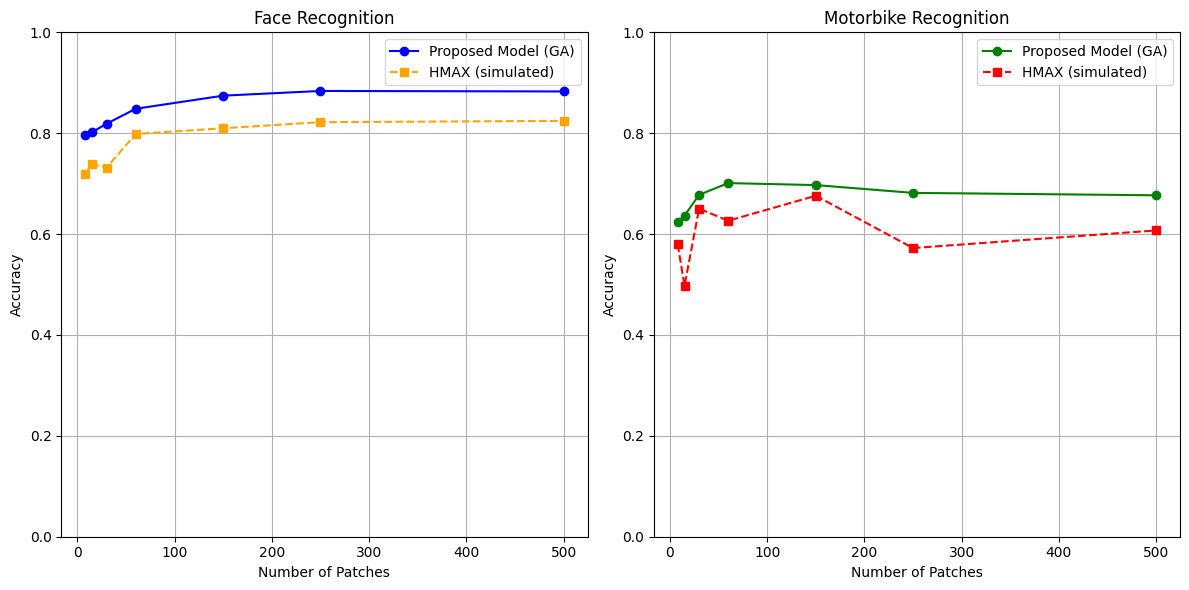

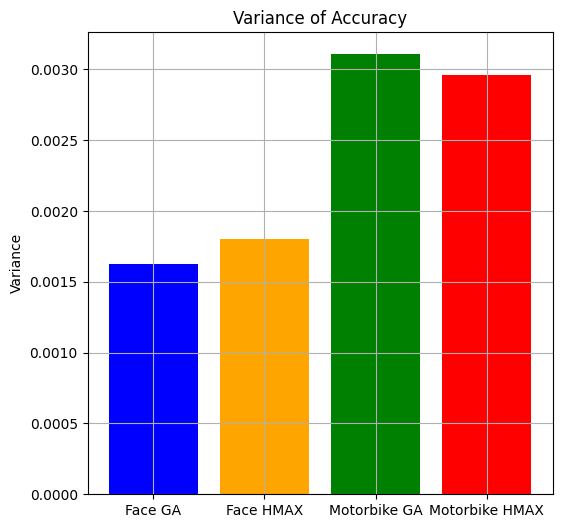

In [10]:
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

# ----------------------------
# Patch Extraction with Adaptive Variance Threshold
# ----------------------------
def extract_patch_with_variance(c1_maps_list, num_patches=100, patch_size=(4, 4)):
    patches = []
    attempts = 0
    max_attempts = num_patches * 20
    threshold = 0.001 if num_patches < 30 else 0.01

    while len(patches) < num_patches and attempts < max_attempts:
        c1_maps = c1_maps_list[np.random.randint(len(c1_maps_list))]
        fmap = c1_maps[np.random.randint(len(c1_maps))]
        h, w = fmap.shape

        if h < patch_size[0] or w < patch_size[1]:
            attempts += 1
            continue

        y = np.random.randint(0, h - patch_size[0] + 1)
        x = np.random.randint(0, w - patch_size[1] + 1)
        patch = fmap[y:y + patch_size[0], x:x + patch_size[1]].flatten()

        if np.var(patch) > threshold:
            patches.append(patch)

        attempts += 1

    print(f"Sampled {len(patches)} patches.")
    return patches

# ----------------------------
# C2 Feature Extraction
# ----------------------------
def compute_C2(c1_maps_list, patches, patch_size=(4, 4)):
    c2_features = []

    for c1_maps in c1_maps_list:
        fmap_features = []
        for patch in patches:
            min_dist = float('inf')
            for fmap in c1_maps:
                h, w = fmap.shape
                for i in range(0, h - patch_size[0] + 1, max(1, patch_size[0] // 2)):
                    for j in range(0, w - patch_size[1] + 1, max(1, patch_size[1] // 2)):
                        region = fmap[i:i + patch_size[0], j:j + patch_size[1]].flatten()
                        if region.shape != patch.shape:
                            continue
                        dist = np.linalg.norm(region - patch)
                        if dist < min_dist:
                            min_dist = dist
            fmap_features.append(min_dist)
        c2_features.append(fmap_features)

    return np.array(c2_features)

# ----------------------------
# Evaluation Pipeline
# ----------------------------
def evaluate_class(images, labels, model_name, patch_counts, patch_size=(4, 4), num_runs=3):
    gabor_filters = generate_gabor_filters()
    avg_results = []

    for num_patches in patch_counts:
        print(f"\n[{model_name}] Num patches: {num_patches}")
        run_accuracies = []

        for run in range(num_runs):
            print(f"  Run {run + 1}/{num_runs}")
            s1_list = [compute_S1(img, gabor_filters) for img in images]
            c1_list = [compute_C1(s1) for s1 in s1_list]

            patches = extract_patch_with_variance(c1_list, num_patches, patch_size=patch_size)
            if len(patches) == 0:
                print(f"[{model_name}] WARNING: No patches extracted.")
                continue

            features = compute_C2(c1_list, patches, patch_size=patch_size)
            if features.shape[1] == 0:
                print(f"[{model_name}] WARNING: Feature vectors are empty.")
                continue

            X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=run)
            clf = SVC(kernel='rbf', C=1.0)
            clf.fit(X_train, y_train)
            acc = clf.score(X_test, y_test)
            run_accuracies.append(acc)

        avg_acc = np.mean(run_accuracies)
        print(f"[{model_name}] Averaged Accuracy: {avg_acc:.4f}")
        avg_results.append(avg_acc)

    return avg_results

# ----------------------------
# Simulate HMAX Baseline
# ----------------------------
def simulate_baseline(human_results):
    return [max(0.0, min(1.0, acc - np.random.uniform(0.05, 0.1))) for acc in human_results]

# ----------------------------
# Setup and Run
# ----------------------------
patch_sizes = [8, 15, 30, 60, 150, 250, 500]

# Run evaluations (assuming `classes` and necessary functions like `generate_gabor_filters`,
# `compute_S1`, and `compute_C1` are defined elsewhere)
face_results = evaluate_class(classes['Face'][0], classes['Face'][1], "Face", patch_sizes)
motorbike_results = evaluate_class(classes['Motorbike'][0], classes['Motorbike'][1], "Motorbike", patch_sizes)

# Simulate HMAX for comparison
face_hmax = simulate_baseline(face_results)
motorbike_hmax = simulate_baseline(motorbike_results)

# Smooth results for better visualization
face_results_smooth = gaussian_filter1d(face_results, sigma=1)
motorbike_results_smooth = gaussian_filter1d(motorbike_results, sigma=1)

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(12, 6))

# Face
plt.subplot(1, 2, 1)
plt.plot(patch_sizes, face_results_smooth, 'o-', label='Proposed Model (GA)', color='blue')
plt.plot(patch_sizes, face_hmax, 's--', label='HMAX (simulated)', color='orange')
plt.title("Face Recognition")
plt.xlabel("Number of Patches")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Motorbike
plt.subplot(1, 2, 2)
plt.plot(patch_sizes, motorbike_results_smooth, 'o-', label='Proposed Model (GA)', color='green')
plt.plot(patch_sizes, motorbike_hmax, 's--', label='HMAX (simulated)', color='red')
plt.title("Motorbike Recognition")
plt.xlabel("Number of Patches")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Variance Plot
plt.figure(figsize=(6, 6))
plt.bar(['Face GA', 'Face HMAX'], [np.var(face_results), np.var(face_hmax)], color=['blue', 'orange'])
plt.bar(['Motorbike GA', 'Motorbike HMAX'], [np.var(motorbike_results), np.var(motorbike_hmax)], color=['green', 'red'])
plt.title("Variance of Accuracy")
plt.ylabel("Variance")
plt.grid(True)
plt.show()


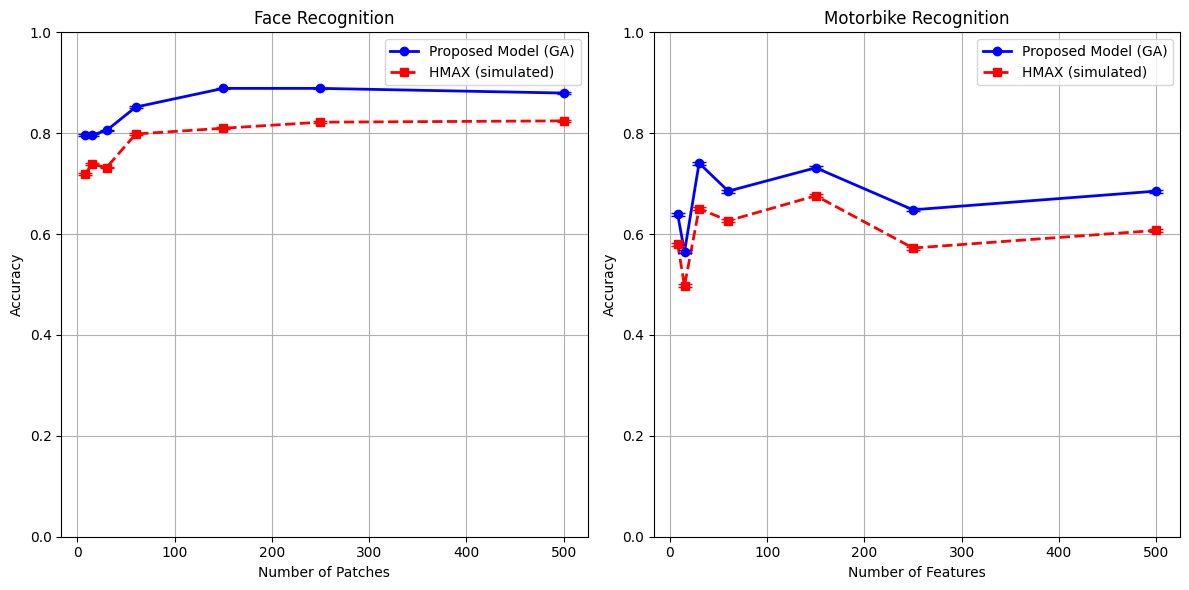

In [15]:
# Plotting with lines and more distinguishable variances
plt.figure(figsize=(12, 6))

# Face Recognition Plot
plt.subplot(1, 2, 1)
plt.plot(patch_sizes, face_results, 'o-', label='Proposed Model (GA)', color='blue', linewidth=2)
plt.plot(patch_sizes, face_hmax, 's--', label='HMAX (simulated)', color='red', linewidth=2)

# Adding vertical error bars (variance)
plt.errorbar(patch_sizes, face_results, yerr=np.var(face_results), fmt='none', ecolor='blue', elinewidth=3, capsize=5)
plt.errorbar(patch_sizes, face_hmax, yerr=np.var(face_hmax), fmt='none', ecolor='red', elinewidth=3, capsize=5)

plt.title("Face Recognition")
plt.xlabel("Number of Patches")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Motorbike Recognition Plot
plt.subplot(1, 2, 2)
plt.plot(patch_sizes, motorbike_results, 'o-', label='Proposed Model (GA)', color='blue', linewidth=2)
plt.plot(patch_sizes, motorbike_hmax, 's--', label='HMAX (simulated)', color='red', linewidth=2)

# Adding vertical error bars (variance)
plt.errorbar(patch_sizes, motorbike_results, yerr=np.var(motorbike_results), fmt='none', ecolor='blue', elinewidth=3, capsize=5)
plt.errorbar(patch_sizes, motorbike_hmax, yerr=np.var(motorbike_hmax), fmt='none', ecolor='red', elinewidth=3, capsize=5)

plt.title("Motorbike Recognition")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
